# Slingshot Trajectory Inference Tutorial

The following is a tutorial on how to run and visualize Slingshot Trajectory Inference on single-cell RNA sequencing data (scRNA-seq).

###### About Slingshot 
Slingshot [(Street et. al, 2018)](https://doi.org/10.1186/s12864-018-4772-0) is a trajectory inference method used to infer cell lineages and pseudotime on scRNA-seq data. Recent comparisons of trajectory inference methods [(Saelens et. al)](https://doi.org/10.1038/s41587-019-0071-9) have described Slingshot to be one of the highest-performing methods; however, it is still advisable to test several types of methods because certain methods are found to yield more accurate results due to dataset variations.

The Slingshot package is written in R. Using previously determined clusters, Slingshot creates minimum spanning trees (MST) through the center of each cluster, helping form a lineage. The trajectory is calculating such that each trajectory has a start and endpoint, where the points can be determined in either a supervised or unsupervised manner based on the cluster. When calculating the trajectory Slingshot the output is twofold as stated by [(Street et. al, 2018)](https://doi.org/10.1186/s12864-018-4772-0): 
1. Lineage Creation: A set of ordered cell clusters with a shared starting cluster and a unique ending cluster. 
2. Pseudotime Determination: A singular value given to each cell describing the cell's progress towards the endpoint.

For a more robust explanation of Slingshot please refer to the following [paper](https://doi.org/10.1186/s12864-018-4772-0). 

###### Preparation for the Pipeline
The pipeline is written Jupyter Notebook and alternates between Python and R languages. Before Trajectory Inference, the scRNA-seq data in this study went through a round of pre-processing and analysis, which included doublet removal, filtration, normalization, batch-effect correction via BBKNN, and clustering. This was all done in python following a Scanpy pipeline, resulting in the information being stored in an AnnData object. To prepare for this tutorial, you may follow tutorials on the Scanpy website. 

###### Overview of the Data in this Tutorial
The data used in this tutorial is of CD14+ Monocytes extracted from a set of PBMCs from a group of healthy and COVID-19 positive infants. The purpose of this study was to study the immunological effects of the coronavirus on three COVID-19 positive groups of infants (G1, G2, G3), with each successive group defined with more severe symptoms.   

## 1. Importing the Requisite Python and R packages

###### Understanding the Import Statements
Here, we import several Python and R packages. If the Scanpy tutorial was used for pre-processing, most of the python packages will already have been installed. 

In order to run R in the notebook, we install and load the rpy2 package. We call R in a notebook cell by typing %%R. To convert the python-based AnnData Object to R, we use the anndata2ri package. This package converts the AnnData object to an R-based SingleCellExperiment Object that will be used to run Slingshot. 

Lastly, we load the R libraries. The libraries should be installed outside the notebook and can be loaded as shown below. 

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
import matplotlib
sc.settings.verbosity = 3 
sc.logging.print_versions()

import warnings
import os
from matplotlib import rcParams
warnings.simplefilter(action='ignore', category=FutureWarning)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.2.0
annoy               NA
appnope             0.1.2
backcall            0.2.0
bbknn               NA
cached_property     1.5.2
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.9.1
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.0
joblib         

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [3]:
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [5]:
%%R
# Loading R libraries
library(RColorBrewer)
library(scran)
library(slingshot)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(scater)
library(ggbeeswarm)

In [6]:
#Read AnnData Object with Clusters
CD14 = sc.read("./H5ADs_pCov/CD14_mono_cleaned_pCov40_07292021.h5ad")
CD14

AnnData object with n_obs × n_vars = 17478 × 1362
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'Res1_2_BC', 'Res1_2_AC', 'Fig_ids_Groups', 'annotated_clusters', 'ISG_score_raw', 'ISG_score', 'INFLAM_score_raw', 'INFLAM_score', 'CD14_mono_Res1', 'CD14_mono_Res0_8', 'CD14_mono_Res0_6', 'CD14_mono_Res0_4', 'IL1B_IFI27', 'IL1B_ISG15', 'IL1B_XAF1', 'CXCL8_IFI27', 'CXCL8_ISG15', 'CXCL8_XAF1', 'Merged_SCs', 'SCs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'CXCL8_IFI27_colors', 'CXCL8_ISG15_colors', 'CXCL8_XAF1_colors', 'Groups_colors', 'IL1B_IFI27_colors', 'IL1B_ISG15_colors', 'IL1B_XAF1_colors', 'Patient_groups_colors', 'SCs_colors', 'dendrogram_SCs', "dendrogram_['CD14_mono_Res0_4']", "dendrogram_['SCs']", 'neighbors', 'rank_genes_groups

## 2. Plotting Clusters & Genes

A requirement to run Slingshot is to have cell clusters present in the object. In our data, the clusters are annotated and called 'SCs.' Below we plot the clusters and the top 10 genes in each cluster, as well as some marker genes to get an understanding of the dataset.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


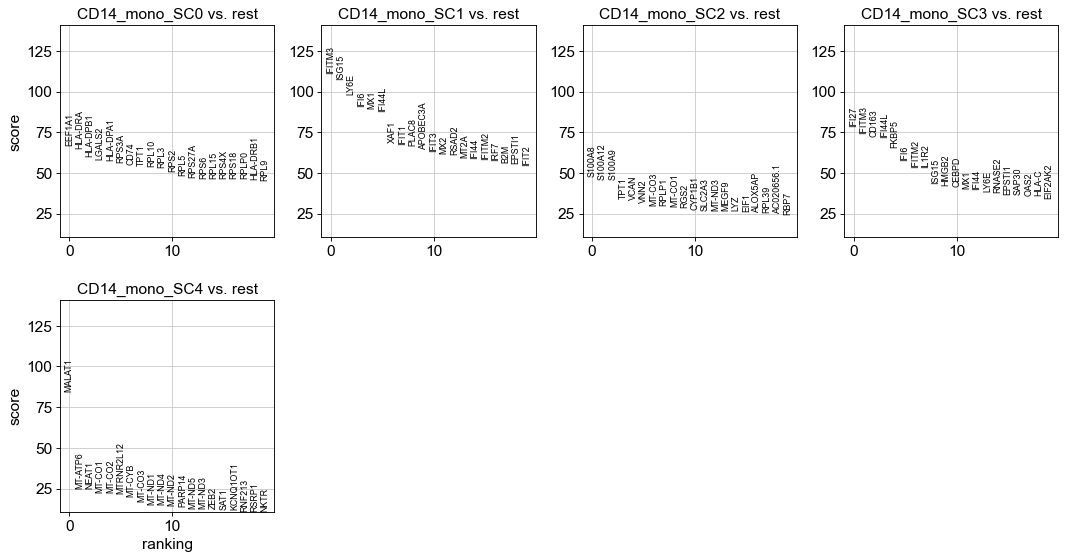

In [7]:
sc.tl.rank_genes_groups(CD14, groupby='SCs', method='t-test')
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(CD14)

In [8]:
#Creating a cluster Dendrogram
sc.tl.dendrogram(CD14, groupby='SCs')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_SCs']`


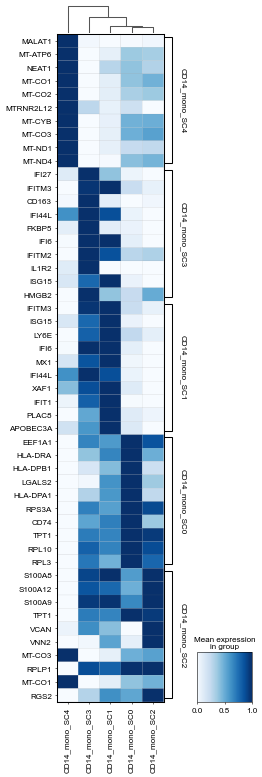

In [9]:
#Matrix Plot of Top 10 Genes per Cluster
matplotlib.style.use('default')
sc.settings.set_figure_params(dpi=50)  # set sufficiently high resolution for saving
axs = sc.pl.rank_genes_groups_matrixplot(CD14, n_genes=10, standard_scale='var', cmap='Blues', figsize=(5,18),swap_axes=True)


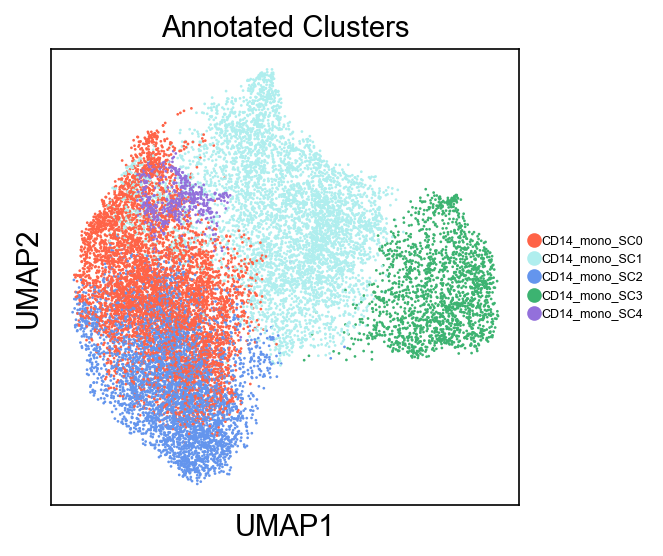

In [10]:
sc.set_figure_params(dpi=150)
colors = ['tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen','mediumpurple', 'goldenrod', 'lightgreen', 
          'palevioletred','lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8']
sc.pl.umap(CD14, color=['SCs'],legend_loc='right margin',frameon=True, 
           title='Annotated Clusters',legend_fontsize=6,palette=colors, legend_fontoutline=1,add_outline=False,)


categories: CD14_mono_SC0, CD14_mono_SC1, CD14_mono_SC2, etc.
var_group_labels: Monocyte Markers, ISG, Chem., etc.


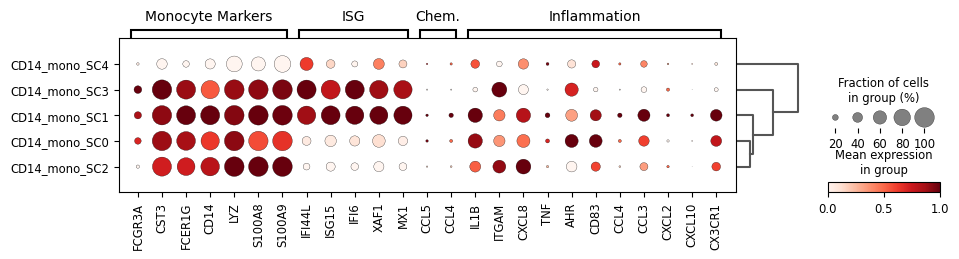

In [11]:
marker_genes_dict = {'Monocyte Markers':["FCGR3A","CST3","FCER1G","CD14","LYZ",'S100A8','S100A9'],
                     'ISG':['IFI44L','ISG15','IFI6','XAF1','MX1'],
                     'Chem.':['CCL5','CCL4'],
                     'Inflammation':['IL1B','ITGAM','CXCL8','TNF','AHR','CD83','CCL4','CCL3','CXCL2','CXCL10','CX3CR1']}

matplotlib.style.use('default')
gs = sc.pl.dotplot(CD14,
                   marker_genes_dict,
                   groupby='SCs',
                   dendrogram=True,
                   standard_scale='var',
                   figsize=(10.6,2),
                   var_group_rotation =0,
                   swap_axes=False)


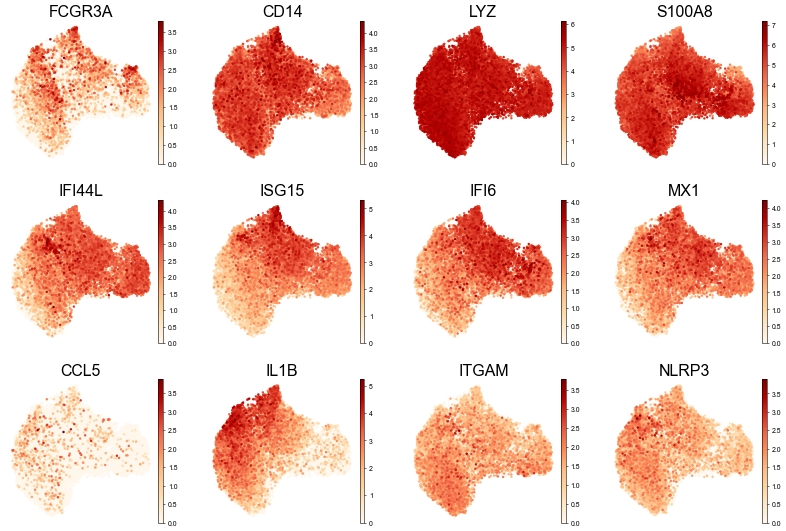

In [12]:
matplotlib.style.use('default')
rcParams['figure.figsize'] = (3,3)
sc.settings.set_figure_params(dpi=50)  # set sufficiently high resolution for saving
plt.rc('font', size=23)          # controls default text sizes
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
genes = ["FCGR3A","CD14","LYZ",'S100A8','IFI44L','ISG15','IFI6','MX1',
         'CCL5','IL1B','ITGAM','NLRP3']
sc.pl.umap(CD14,
           color=genes,
           color_map='OrRd',
           legend_loc='on data',
           legend_fontsize=10,
           size=50,
           ncols=4,
           frameon=False)


In [13]:
#Re-order the Patient Groups for more organized plot labeling later in the pipeline.  
CD14.obs['Patient_groups'] = CD14.obs['Patient_groups'].cat.reorder_categories(['G3','G2','G1','pHC'])
CD14.obs['Patient_groups'].value_counts(sort=False)


G3     2607
G2     4145
G1     5992
pHC    4734
Name: Patient_groups, dtype: int64

## 3. Slingshot Trajectory Inference

### 3.1 Converting AnnData to SingleCellExperiment Object

In [14]:
%%R -i CD14

#Convert AnnData to SingleCellExperiment Object
print(CD14)

/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


class: SingleCellExperiment 
dim: 1362 17478 
metadata(15): CXCL8_IFI27_colors CXCL8_ISG15_colors ...
  rank_genes_groups umap
assays(2): X scaled
rownames(1362): HES4 ISG15 ... DIP2A S100B
rowData names(9): gene_ids feature_types ... mean std
colnames(17478): AAAGGATGTACAGCGA-1 ACAAAGATCCTTATAC-1 ...
  TTTGGAGGTGGTAATA-40 TTTGGTTCATAAGCGG-40
colData names(36): Cells Samples ... Merged_SCs SCs
reducedDimNames(2): PCA UMAP
altExpNames(0):


### 3.2 Running Slingshot & Merging Lineages
Here we begin to run Slingshot. As shown below, we assign the output of the Slingshot wrapper function to "adata_sling," thus creating a slingshot object. We enter several parameters, most notably a starting cluster (start.clus) and a reduced dimension (reducedDim). The reducedDim can be set either UMAP or PCA.  

In Slingshot, an ending cluster (end.clus) can also be defined, however in this tutorial we leave it unsupervised. To reduce the computation time and memory, you can also set an "approx_points" parameter to 100. In doing so, the points on the slingshot curve will be limited to 100. 

Please note, that in this tutorial we test several different starting clusters to see which one yields the most accurate result. 
###### Start Cluster: CD14_mono_SC0

In [15]:
%%R 
print("0:")
adata_sling <- slingshot(CD14, clusterLabels = 'SCs',start.clus='CD14_mono_SC0', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling))

[1] "0:"
class: SlingshotDataSet 

 Samples Dimensions
   17478          3

lineages: 3 
Lineage1: CD14_mono_SC0  CD14_mono_SC1  CD14_mono_SC4  
Lineage2: CD14_mono_SC0  CD14_mono_SC1  CD14_mono_SC3  
Lineage3: CD14_mono_SC0  CD14_mono_SC2  

curves: 3 
Curve1: Length: 14.549	Samples: 8373.61
Curve2: Length: 15.62	Samples: 10222.17
Curve3: Length: 14.748	Samples: 9534.84


As you can see, the output of this Slingshot run produced three lineages, where each lineage is defined by an order set of clusters all starting at "CD14_mono_SC0." Each of the curves—which corespond to the lineage—captures a certain number of "samples" or cells. 

For the sake of clarity in the plots (makes more sense later on), we merge each of the lineages. This is done by taking the average pseudotime of each cell across each of the lineages.  

In [16]:
%%R

cells <- CD14$Cells
sling1 <- adata_sling$slingPseudotime_1
sling2 <- adata_sling$slingPseudotime_2
sling3 <- adata_sling$slingPseudotime_3


#Combining Slingshot Pseudotime Values into a Dataframe and saving as .csv file
df = data.frame(cells = cells, slingPseudotime_1 = sling1, slingPseudotime_2 = sling2,slingPseudotime_3 = sling3)
write.csv(df,'./Files/CD14_df_0.csv')


In [17]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./Files/CD14_df_0.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_0'] = col.mean(axis=1)

sling_df.head()

#Loading Slingshot Pseudotime Values into AnnData Object
CD14.obs['sling_avg_0'] = sling_df['sling_avg_0']
CD14.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAAGGATGTACAGCGA-1  AAAGGATGTACAGCGA-1       1  JB19050  HPIR_021_1    pHC1   
ACAAAGATCCTTATAC-1  ACAAAGATCCTTATAC-1       1  JB19050  HPIR_021_1    pHC1   
ACCGTTCTCAAATGCC-1  ACCGTTCTCAAATGCC-1       1  JB19050  HPIR_021_1    pHC1   
ACTATGGCAAGATTGA-1  ACTATGGCAAGATTGA-1       1  JB19050  HPIR_021_1    pHC1   
ACTGTCCAGATAGCTA-1  ACTGTCCAGATAGCTA-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ...  \
AAAGGATGTACAGCGA-1    pHC         W       2.17       B1  2020  ...   
ACAAAGATCCTTATAC-1    pHC         W       2.17       B1  2020  ...   
ACCGTTCTCAAATGCC-1    pHC         W       2.17       B1  2020  ...   
ACTATGGCAAGATTGA-1    pHC         W       2.17       B1  2020  ...   
ACTGTCCAGATAGCTA-1    pHC         W       2.17       B1  2020  ...   

                   CD14_mono_Res0_4  IL1B_IFI27 IL1B_ISG15  IL1B_XAF1  \
AAAGGATGTACAGCGA-1                0        IL1B       IL1B       IL1B   
ACAAAGATCCTTATAC-1                0        IL1B       IL1B       IL1B   
ACCGTTCTCAAATGCC-1                0        IL1B       IL1B       IL1B   
ACTATGGCAAGATTGA-1                0        IL1B       IL1B       IL1B   
ACTGTCCAGATAGCTA-1                2     Neither    Neither       XAF1   

                    CXCL8_IFI27  CXCL8_ISG15  CXCL8_XAF1 Merged_SCs  \
AAAGGATGTACAGCGA-1        CXCL8        CXCL8       CXCL8          0   
ACAAAGATCCTTATAC-1        CXCL8        CXCL8       CXCL8          0   
ACCGTTCTCAAATGCC-1        CXCL8        CXCL8       CXCL8          0   
ACTATGGCAAGATTGA-1        CXCL8        CXCL8       CXCL8          0   
ACTGTCCAGATAGCTA-1        CXCL8        CXCL8  CXCL8_XAF1          2   

                              SCs sling_avg_0  
AAAGGATGTACAGCGA-1  CD14_mono_SC0    6.354636  
ACAAAGATCCTTATAC-1  CD14_mono_SC0    2.237999  
ACCGTTCTCAAATGCC-1  CD14_mono_SC0    1.757143  
ACTATGGCAAGATTGA-1  CD14_mono_SC0    5.843819  
ACTGTCCAGATAGCTA-1  CD14_mono_SC2   10.508943  

[5 rows x 37 columns]

We run slingshot by repeating the above steps, except this time we change the starting cluster.
###### Start Cluster: CD14_mono_SC1

In [18]:
%%R 
#--- Note the use of approx_points here
print("1:")
adata_sling_1 <- slingshot(CD14, clusterLabels = 'SCs',start.clus='CD14_mono_SC1', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_1))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
   17478          3

lineages: 3 
Lineage1: CD14_mono_SC1  CD14_mono_SC0  CD14_mono_SC2  
Lineage2: CD14_mono_SC1  CD14_mono_SC4  
Lineage3: CD14_mono_SC1  CD14_mono_SC3  

curves: 3 
Curve1: Length: 18.232	Samples: 13594.55
Curve2: Length: 12.233	Samples: 5233.39
Curve3: Length: 14.954	Samples: 6280.31


In [19]:
%%R

cells <- CD14$Cells
sling1 <- adata_sling_1$slingPseudotime_1
sling2 <- adata_sling_1$slingPseudotime_2
sling3 <- adata_sling_1$slingPseudotime_3


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1, slingPseudotime_2 = sling2, slingPseudotime_3=sling3)
write.csv(df,'./Files/CD14_df_1.csv')


In [20]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./Files/CD14_df_1.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_1'] = col.mean(axis=1)

sling_df.head()

CD14.obs['sling_avg_1'] = sling_df['sling_avg_1']
CD14.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAAGGATGTACAGCGA-1  AAAGGATGTACAGCGA-1       1  JB19050  HPIR_021_1    pHC1   
ACAAAGATCCTTATAC-1  ACAAAGATCCTTATAC-1       1  JB19050  HPIR_021_1    pHC1   
ACCGTTCTCAAATGCC-1  ACCGTTCTCAAATGCC-1       1  JB19050  HPIR_021_1    pHC1   
ACTATGGCAAGATTGA-1  ACTATGGCAAGATTGA-1       1  JB19050  HPIR_021_1    pHC1   
ACTGTCCAGATAGCTA-1  ACTGTCCAGATAGCTA-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ... IL1B_IFI27  \
AAAGGATGTACAGCGA-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACAAAGATCCTTATAC-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACCGTTCTCAAATGCC-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACTATGGCAAGATTGA-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACTGTCCAGATAGCTA-1    pHC         W       2.17       B1  2020  ...    Neither   

                    IL1B_ISG15 IL1B_XAF1  CXCL8_IFI27  CXCL8_ISG15  \
AAAGGATGTACAGCGA-1        IL1B      IL1B        CXCL8        CXCL8   
ACAAAGATCCTTATAC-1        IL1B      IL1B        CXCL8        CXCL8   
ACCGTTCTCAAATGCC-1        IL1B      IL1B        CXCL8        CXCL8   
ACTATGGCAAGATTGA-1        IL1B      IL1B        CXCL8        CXCL8   
ACTGTCCAGATAGCTA-1     Neither      XAF1        CXCL8        CXCL8   

                    CXCL8_XAF1 Merged_SCs            SCs sling_avg_0  \
AAAGGATGTACAGCGA-1       CXCL8          0  CD14_mono_SC0    6.354636   
ACAAAGATCCTTATAC-1       CXCL8          0  CD14_mono_SC0    2.237999   
ACCGTTCTCAAATGCC-1       CXCL8          0  CD14_mono_SC0    1.757143   
ACTATGGCAAGATTGA-1       CXCL8          0  CD14_mono_SC0    5.843819   
ACTGTCCAGATAGCTA-1  CXCL8_XAF1          2  CD14_mono_SC2   10.508943   

                   sling_avg_1  
AAAGGATGTACAGCGA-1    8.840978  
ACAAAGATCCTTATAC-1    9.899226  
ACCGTTCTCAAATGCC-1    9.733960  
ACTATGGCAAGATTGA-1    9.442185  
ACTGTCCAGATAGCTA-1   14.932298  

[5 rows x 38 columns]

###### Start Cluster: CD14_mono_SC2

In [21]:
%%R 
print("2:")
adata_sling_2 <- slingshot(CD14, clusterLabels = 'SCs',start.clus='CD14_mono_SC2', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_2))

[1] "2:"
class: SlingshotDataSet 

 Samples Dimensions
   17478          3

lineages: 2 
Lineage1: CD14_mono_SC2  CD14_mono_SC0  CD14_mono_SC1  CD14_mono_SC4  
Lineage2: CD14_mono_SC2  CD14_mono_SC0  CD14_mono_SC1  CD14_mono_SC3  

curves: 2 
Curve1: Length: 16.048	Samples: 13673.7
Curve2: Length: 17.553	Samples: 15355.46


In [22]:
%%R

cells <- CD14$Cells
sling1 <- adata_sling_2$slingPseudotime_1
sling2 <- adata_sling_2$slingPseudotime_2


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1, slingPseudotime_2 = sling2)
write.csv(df,'./Files/CD14_df_2.csv')


In [23]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./Files/CD14_df_2.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_2'] = col.mean(axis=1)

sling_df.head()

CD14.obs['sling_avg_2'] = sling_df['sling_avg_2']
CD14.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAAGGATGTACAGCGA-1  AAAGGATGTACAGCGA-1       1  JB19050  HPIR_021_1    pHC1   
ACAAAGATCCTTATAC-1  ACAAAGATCCTTATAC-1       1  JB19050  HPIR_021_1    pHC1   
ACCGTTCTCAAATGCC-1  ACCGTTCTCAAATGCC-1       1  JB19050  HPIR_021_1    pHC1   
ACTATGGCAAGATTGA-1  ACTATGGCAAGATTGA-1       1  JB19050  HPIR_021_1    pHC1   
ACTGTCCAGATAGCTA-1  ACTGTCCAGATAGCTA-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ... IL1B_ISG15  \
AAAGGATGTACAGCGA-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACAAAGATCCTTATAC-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACCGTTCTCAAATGCC-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACTATGGCAAGATTGA-1    pHC         W       2.17       B1  2020  ...       IL1B   
ACTGTCCAGATAGCTA-1    pHC         W       2.17       B1  2020  ...    Neither   

                    IL1B_XAF1 CXCL8_IFI27  CXCL8_ISG15  CXCL8_XAF1  \
AAAGGATGTACAGCGA-1       IL1B       CXCL8        CXCL8       CXCL8   
ACAAAGATCCTTATAC-1       IL1B       CXCL8        CXCL8       CXCL8   
ACCGTTCTCAAATGCC-1       IL1B       CXCL8        CXCL8       CXCL8   
ACTATGGCAAGATTGA-1       IL1B       CXCL8        CXCL8       CXCL8   
ACTGTCCAGATAGCTA-1       XAF1       CXCL8        CXCL8  CXCL8_XAF1   

                    Merged_SCs            SCs sling_avg_0 sling_avg_1  \
AAAGGATGTACAGCGA-1           0  CD14_mono_SC0    6.354636    8.840978   
ACAAAGATCCTTATAC-1           0  CD14_mono_SC0    2.237999    9.899226   
ACCGTTCTCAAATGCC-1           0  CD14_mono_SC0    1.757143    9.733960   
ACTATGGCAAGATTGA-1           0  CD14_mono_SC0    5.843819    9.442185   
ACTGTCCAGATAGCTA-1           2  CD14_mono_SC2   10.508943   14.932298   

                   sling_avg_2  
AAAGGATGTACAGCGA-1    8.704542  
ACAAAGATCCTTATAC-1    7.130024  
ACCGTTCTCAAATGCC-1    7.573159  
ACTATGGCAAGATTGA-1    7.496980  
ACTGTCCAGATAGCTA-1    3.576738  

[5 rows x 39 columns]

###### Start Cluster: CD14_mono_SC3

In [24]:
%%R 
print("3:")
adata_sling_3 <- slingshot(CD14, clusterLabels = 'SCs',start.clus='CD14_mono_SC3', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_3))

[1] "3:"
class: SlingshotDataSet 

 Samples Dimensions
   17478          3

lineages: 2 
Lineage1: CD14_mono_SC3  CD14_mono_SC1  CD14_mono_SC0  CD14_mono_SC2  
Lineage2: CD14_mono_SC3  CD14_mono_SC1  CD14_mono_SC4  

curves: 2 
Curve1: Length: 17.734	Samples: 15634.98
Curve2: Length: 12.059	Samples: 7045.83


In [25]:
%%R

cells <- CD14$Cells
sling1 <- adata_sling_3$slingPseudotime_1
sling2 <- adata_sling_3$slingPseudotime_2


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1, slingPseudotime_2 = sling2)
write.csv(df,'./Files/CD14_df_3.csv')


In [26]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./Files/CD14_df_3.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_3'] = col.mean(axis=1)

sling_df.head()

CD14.obs['sling_avg_3'] = sling_df['sling_avg_3']
CD14.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAAGGATGTACAGCGA-1  AAAGGATGTACAGCGA-1       1  JB19050  HPIR_021_1    pHC1   
ACAAAGATCCTTATAC-1  ACAAAGATCCTTATAC-1       1  JB19050  HPIR_021_1    pHC1   
ACCGTTCTCAAATGCC-1  ACCGTTCTCAAATGCC-1       1  JB19050  HPIR_021_1    pHC1   
ACTATGGCAAGATTGA-1  ACTATGGCAAGATTGA-1       1  JB19050  HPIR_021_1    pHC1   
ACTGTCCAGATAGCTA-1  ACTGTCCAGATAGCTA-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ... IL1B_XAF1  \
AAAGGATGTACAGCGA-1    pHC         W       2.17       B1  2020  ...      IL1B   
ACAAAGATCCTTATAC-1    pHC         W       2.17       B1  2020  ...      IL1B   
ACCGTTCTCAAATGCC-1    pHC         W       2.17       B1  2020  ...      IL1B   
ACTATGGCAAGATTGA-1    pHC         W       2.17       B1  2020  ...      IL1B   
ACTGTCCAGATAGCTA-1    pHC         W       2.17       B1  2020  ...      XAF1   

                    CXCL8_IFI27 CXCL8_ISG15  CXCL8_XAF1  Merged_SCs  \
AAAGGATGTACAGCGA-1        CXCL8       CXCL8       CXCL8           0   
ACAAAGATCCTTATAC-1        CXCL8       CXCL8       CXCL8           0   
ACCGTTCTCAAATGCC-1        CXCL8       CXCL8       CXCL8           0   
ACTATGGCAAGATTGA-1        CXCL8       CXCL8       CXCL8           0   
ACTGTCCAGATAGCTA-1        CXCL8       CXCL8  CXCL8_XAF1           2   

                              SCs sling_avg_0 sling_avg_1 sling_avg_2  \
AAAGGATGTACAGCGA-1  CD14_mono_SC0    6.354636    8.840978    8.704542   
ACAAAGATCCTTATAC-1  CD14_mono_SC0    2.237999    9.899226    7.130024   
ACCGTTCTCAAATGCC-1  CD14_mono_SC0    1.757143    9.733960    7.573159   
ACTATGGCAAGATTGA-1  CD14_mono_SC0    5.843819    9.442185    7.496980   
ACTGTCCAGATAGCTA-1  CD14_mono_SC2   10.508943   14.932298    3.576738   

                   sling_avg_3  
AAAGGATGTACAGCGA-1    8.713363  
ACAAAGATCCTTATAC-1    9.856720  
ACCGTTCTCAAATGCC-1    9.678823  
ACTATGGCAAGATTGA-1    9.363579  
ACTGTCCAGATAGCTA-1   14.171961  

[5 rows x 40 columns]

###### Start Cluster: CD14_mono_SC4

In [27]:
%%R 
print("4:")
adata_sling_4 <- slingshot(CD14, clusterLabels = 'SCs',start.clus='CD14_mono_SC4', reducedDim = 'UMAP', approx_points = 100)
print(SlingshotDataSet(adata_sling_4))

[1] "4:"
class: SlingshotDataSet 

 Samples Dimensions
   17478          3

lineages: 2 
Lineage1: CD14_mono_SC4  CD14_mono_SC1  CD14_mono_SC0  CD14_mono_SC2  
Lineage2: CD14_mono_SC4  CD14_mono_SC1  CD14_mono_SC3  

curves: 2 
Curve1: Length: 15.92	Samples: 14082.83
Curve2: Length: 12.033	Samples: 7132.67


In [28]:
%%R

cells <- CD14$Cells
sling1 <- adata_sling_4$slingPseudotime_1
sling2 <- adata_sling_4$slingPseudotime_2


#Combining Slingshot Pseudotime Values into a Dataframe
df = data.frame(cells = cells, slingPseudotime_1 = sling1,slingPseudotime_2 = sling2)
write.csv(df,'./Files/CD14_df_4.csv')


In [29]:
#Reading Slingshot Pseudotime Values into a Pandas Dataframe
sling_df = pd.read_csv('./Files/CD14_df_4.csv')
del sling_df['Unnamed: 0']
sling_df =sling_df.set_index("cells")

#Taking average of Slingshot Pseudotime Values
col = sling_df.loc[: , "slingPseudotime_1":"slingPseudotime_4"]
sling_df['sling_avg_4'] = col.mean(axis=1)

sling_df.head()

CD14.obs['sling_avg_4'] = sling_df['sling_avg_4']
CD14.obs.head()

Cells Samples      IDs       Names Fig_ids  \
AAAGGATGTACAGCGA-1  AAAGGATGTACAGCGA-1       1  JB19050  HPIR_021_1    pHC1   
ACAAAGATCCTTATAC-1  ACAAAGATCCTTATAC-1       1  JB19050  HPIR_021_1    pHC1   
ACCGTTCTCAAATGCC-1  ACCGTTCTCAAATGCC-1       1  JB19050  HPIR_021_1    pHC1   
ACTATGGCAAGATTGA-1  ACTATGGCAAGATTGA-1       1  JB19050  HPIR_021_1    pHC1   
ACTGTCCAGATAGCTA-1  ACTGTCCAGATAGCTA-1       1  JB19050  HPIR_021_1    pHC1   

                   Groups Ethnicity Age_Months runs_10X  Year  ...  \
AAAGGATGTACAGCGA-1    pHC         W       2.17       B1  2020  ...   
ACAAAGATCCTTATAC-1    pHC         W       2.17       B1  2020  ...   
ACCGTTCTCAAATGCC-1    pHC         W       2.17       B1  2020  ...   
ACTATGGCAAGATTGA-1    pHC         W       2.17       B1  2020  ...   
ACTGTCCAGATAGCTA-1    pHC         W       2.17       B1  2020  ...   

                   CXCL8_IFI27  CXCL8_ISG15  CXCL8_XAF1  Merged_SCs  \
AAAGGATGTACAGCGA-1       CXCL8        CXCL8       CXCL8           0   
ACAAAGATCCTTATAC-1       CXCL8        CXCL8       CXCL8           0   
ACCGTTCTCAAATGCC-1       CXCL8        CXCL8       CXCL8           0   
ACTATGGCAAGATTGA-1       CXCL8        CXCL8       CXCL8           0   
ACTGTCCAGATAGCTA-1       CXCL8        CXCL8  CXCL8_XAF1           2   

                              SCs  sling_avg_0 sling_avg_1 sling_avg_2  \
AAAGGATGTACAGCGA-1  CD14_mono_SC0     6.354636    8.840978    8.704542   
ACAAAGATCCTTATAC-1  CD14_mono_SC0     2.237999    9.899226    7.130024   
ACCGTTCTCAAATGCC-1  CD14_mono_SC0     1.757143    9.733960    7.573159   
ACTATGGCAAGATTGA-1  CD14_mono_SC0     5.843819    9.442185    7.496980   
ACTGTCCAGATAGCTA-1  CD14_mono_SC2    10.508943   14.932298    3.576738   

                   sling_avg_3 sling_avg_4  
AAAGGATGTACAGCGA-1    8.713363    8.932932  
ACAAAGATCCTTATAC-1    9.856720    9.326582  
ACCGTTCTCAAATGCC-1    9.678823    8.688618  
ACTATGGCAAGATTGA-1    9.363579    9.203261  
ACTGTCCAGATAGCTA-1   14.171961   12.165118  

[5 rows x 41 columns]

In [30]:
# Saving AnnData Object containing pseudotime values
CD14.write("./Files/CD14_pCov_Trajectory.h5ad")

## 4. Plotting Slingshot Values
Here we plot the Slingshot lineages and pseudotime in several representations.

In [31]:
%%R
#Setting Group Colors
col_Groups = c('pCov'="#9E9AC8",'pHC'="#66BD63")
col_pGroups = c('G3'="#54278F",'G2'="#9E9AC8", 'G1'="#D8DAEB", 'pHC'="#66BD63")

In [32]:
%%R
#Setting Plot Theme
THEME <- theme(axis.text.y=element_text(size=16),
                    axis.text.x=element_text(size=16, angle = 90),
                    axis.title.x = element_text(face="bold", size=14),
                    axis.title.y = element_text(face="bold", size=14),
                    plot.title = element_text(hjust = 0.5,face='bold',size=14),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_rect(fill='white', colour='white'),
                    panel.border = element_rect(fill=NA, color = 'black', size=1),
                    legend.direction = "horizontal", legend.position = 'bottom', legend.text.align = 1,
                    legend.text = element_text(size=9),
                    legend.key.size = unit(0.4, "cm"),
                    legend.key.width = unit(0.4,"cm"))

In [33]:
%%R
#Setting Cluster colors
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

### 4.1 Plotting Start Clus: CD14_mono_SC0

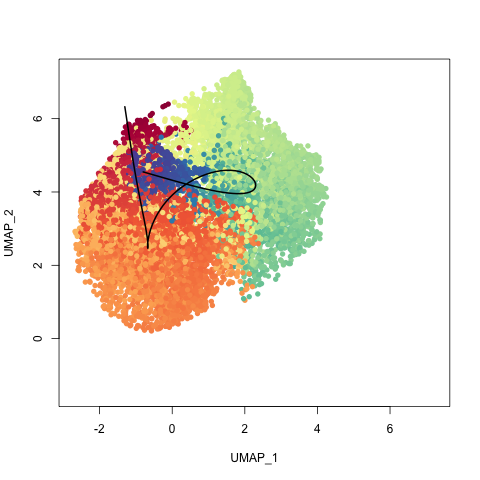

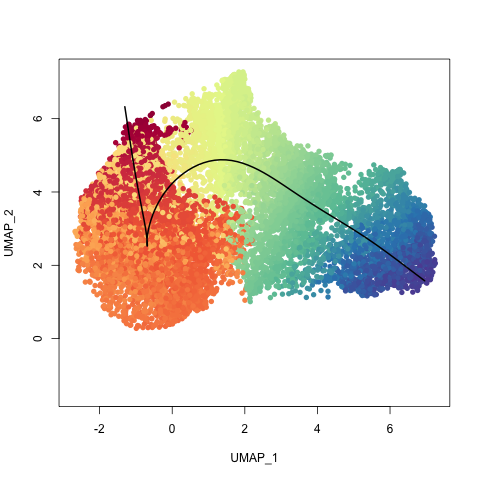

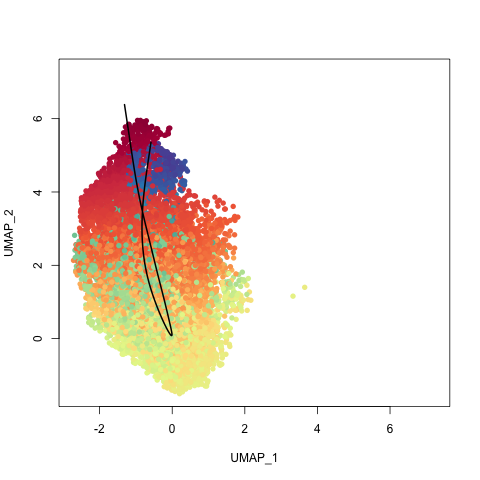

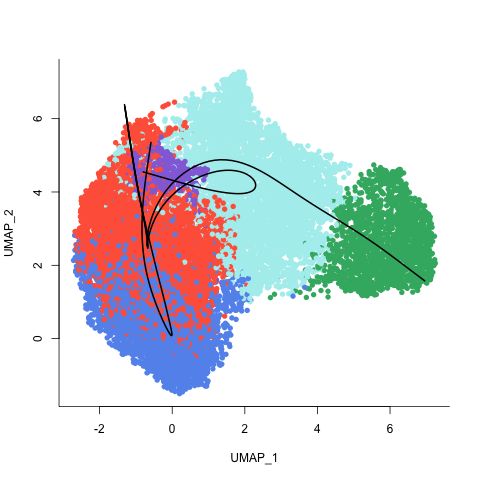

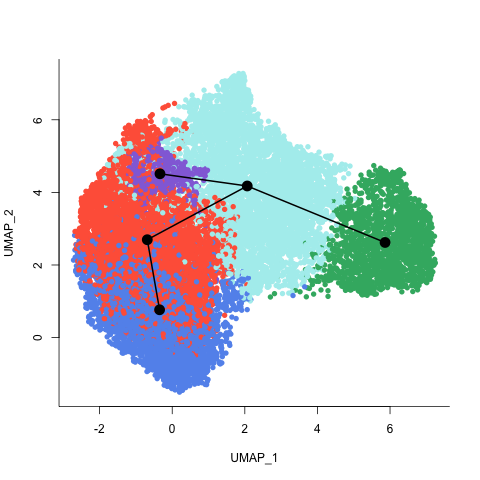

In [34]:
%%R 
#---- Plotting Slingshot lineages and curves

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling)$curve2, lwd=2)

#Plot of lineage 3
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colors[cut(adata_sling$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling)$curve3, lwd=2)

#Plot of All Lineages
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling)$UMAP, col = colour_map[CD14$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling)$curve1,lwd=2) + lines(slingCurves(adata_sling)$curve2,lwd=2) + lines(slingCurves(adata_sling)$curve3,lwd=2)+ lines(slingCurves(adata_sling)$curve4,lwd=2) + lines(slingCurves(adata_sling)$curve5,lwd=2)+lines(slingCurves(adata_sling)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(CD14)$CD14cells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling)$UMAP[,c(1,2)], col = colour_map[CD14$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling), lwd=2, type='lineages')

/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


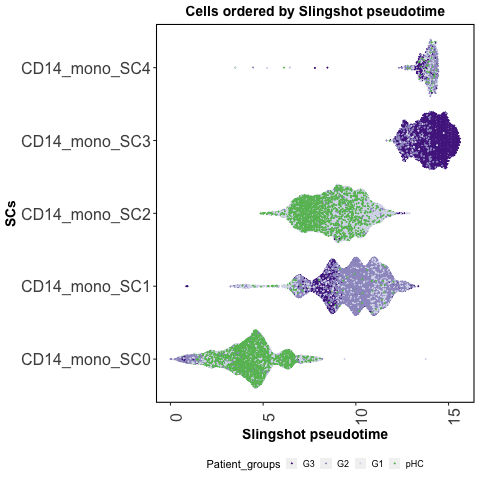

In [35]:
%%R -i CD14
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_0, y = SCs, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")

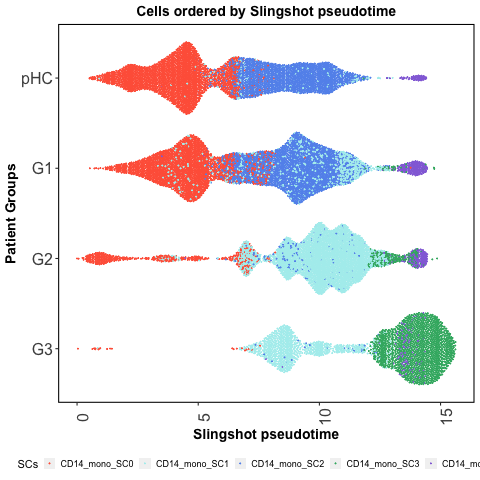

In [36]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_0, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ylab("Patient Groups") + ggtitle("Cells ordered by Slingshot pseudotime")


### 4.2 Plotting Start Clus: CD14_mono_SC1

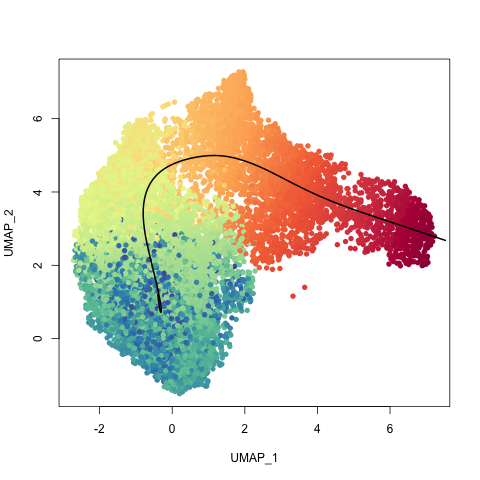

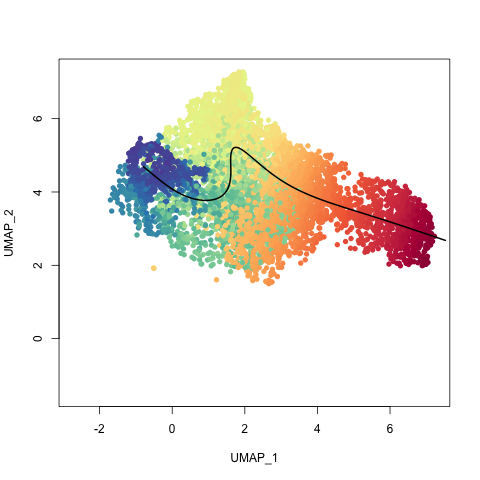

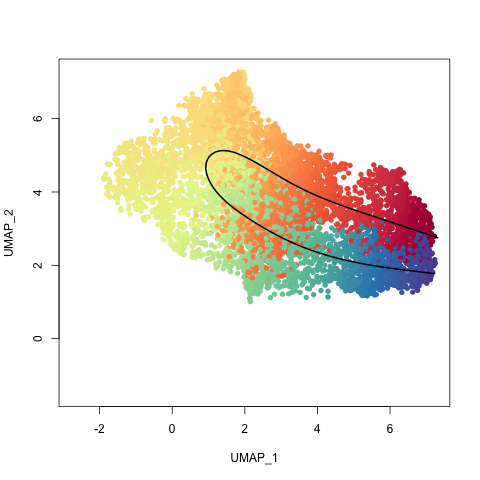

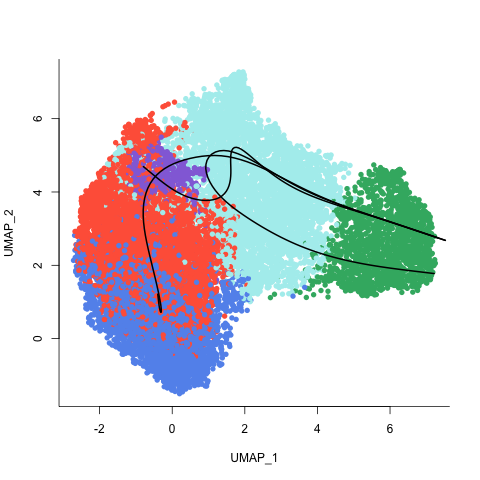

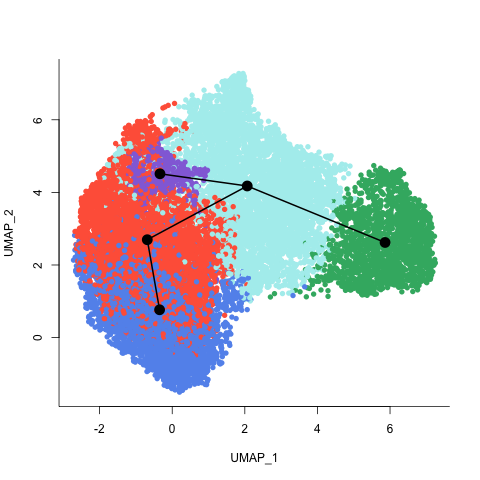

In [37]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_1)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_1)$curve2, lwd=2)

#Plot of lineage 3
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colors[cut(adata_sling_1$slingPseudotime_3,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_1)$curve3, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_1)$UMAP, col = colour_map[CD14$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_1)$curve1,lwd=2) + lines(slingCurves(adata_sling_1)$curve2,lwd=2) + lines(slingCurves(adata_sling_1)$curve3,lwd=2)+ lines(slingCurves(adata_sling_1)$curve4,lwd=2) + lines(slingCurves(adata_sling_1)$curve5,lwd=2)+lines(slingCurves(adata_sling_1)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(CD14)$CD14cells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_1)$UMAP[,c(1,2)], col = colour_map[CD14$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_1), lwd=2, type='lineages')

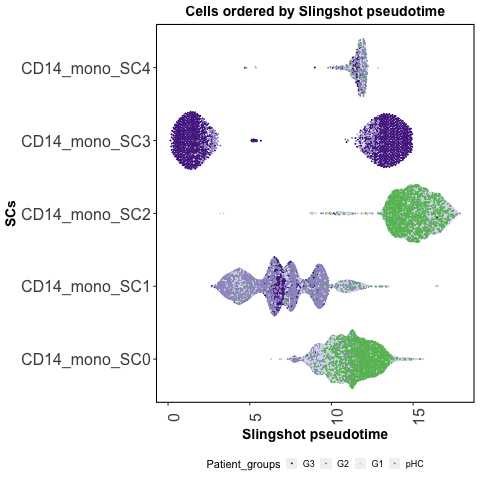

In [38]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_1, y = SCs, colour = Patient_groups)) + geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


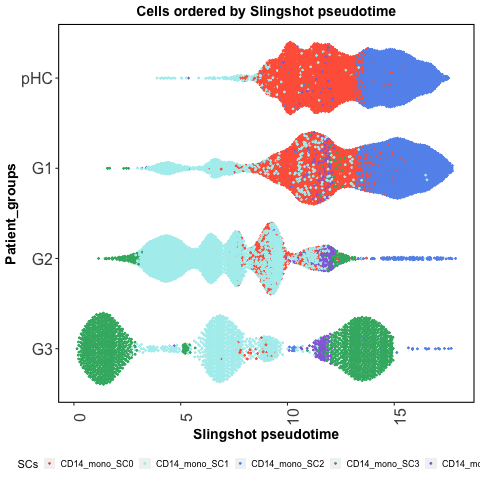

In [39]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_1, y = Patient_groups, colour = SCs)) + geom_quasirandom(groupOnX = FALSE,size = 0.5) + scale_color_manual(values = colour_map) + THEME + xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


### 4.3 Plotting Start Clus: CD14_mono_SC2

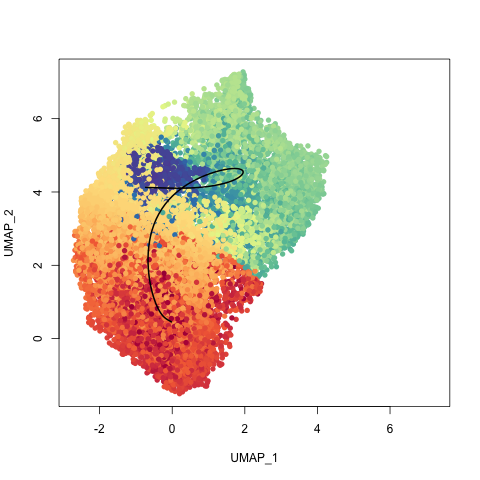

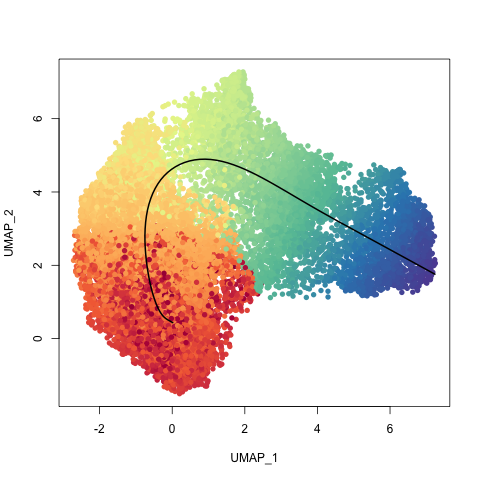

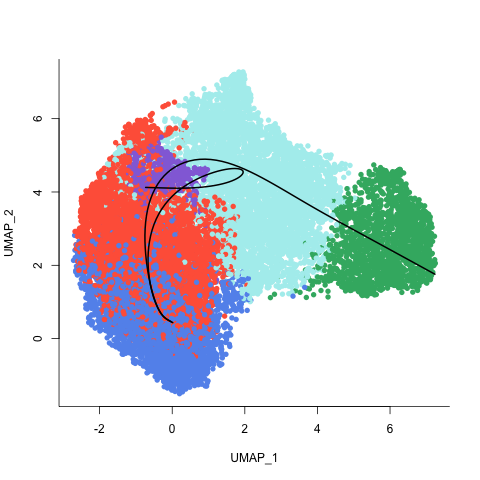

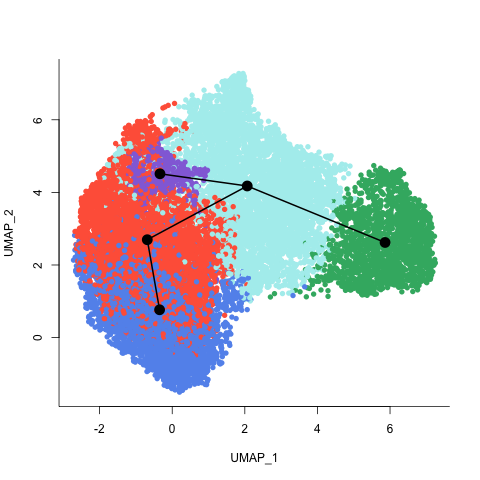

In [40]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_2)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colors[cut(adata_sling_2$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_2)$curve2, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_2)$UMAP, col = colour_map[CD14$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_2)$curve1,lwd=2) + lines(slingCurves(adata_sling_2)$curve2,lwd=2) + lines(slingCurves(adata_sling_2)$curve3,lwd=2)+ lines(slingCurves(adata_sling_2)$curve4,lwd=2) + lines(slingCurves(adata_sling_2)$curve5,lwd=2)+lines(slingCurves(adata_sling_2)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(CD14)$CD14cells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_2)$UMAP[,c(1,2)], col = colour_map[CD14$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_2), lwd=2, type='lineages')

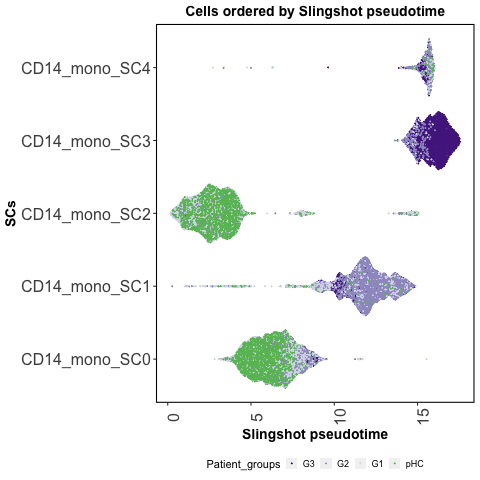

In [41]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_2, y = SCs, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")

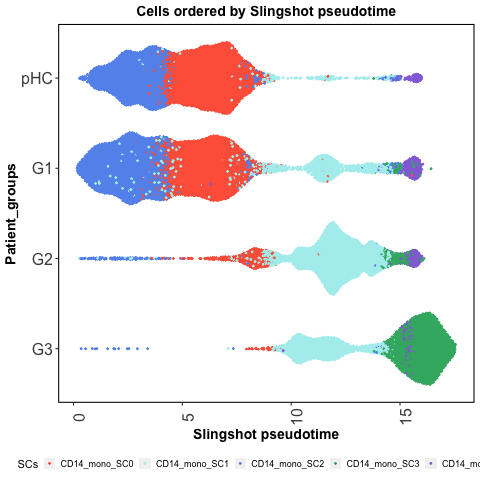

In [42]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_2, y = Patient_groups, colour = SCs)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.5) + scale_color_manual(values = colour_map) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")

### 4.4 Plotting Start Clus: CD14_mono_SC3

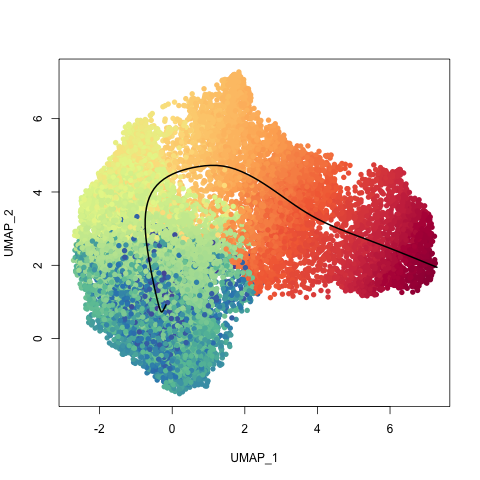

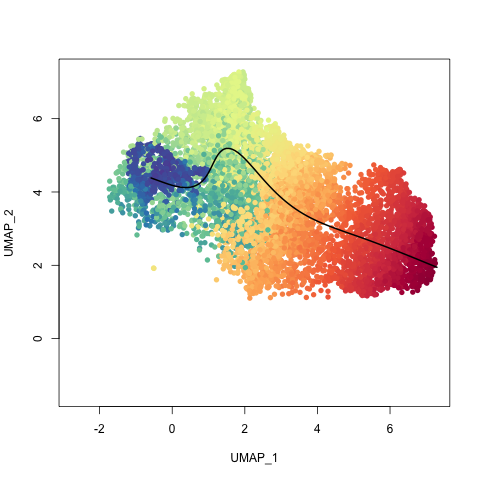

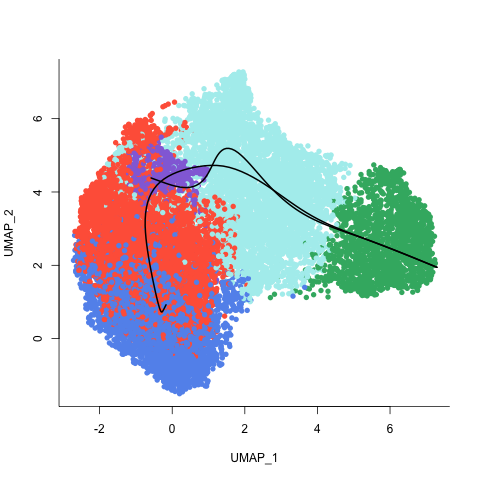

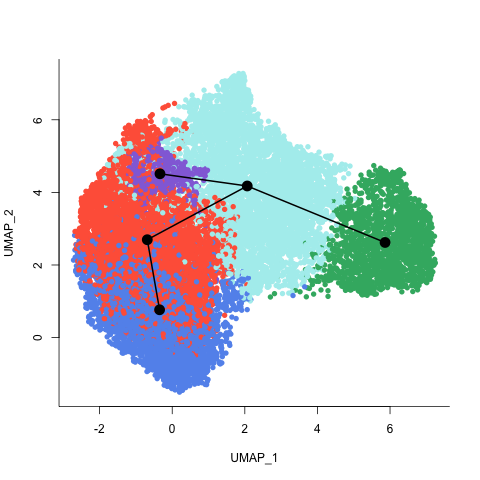

In [43]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_3)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colors[cut(adata_sling_3$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_3)$curve2, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_3)$UMAP, col = colour_map[CD14$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_3)$curve1,lwd=2) + lines(slingCurves(adata_sling_3)$curve2,lwd=2) + lines(slingCurves(adata_sling_3)$curve3,lwd=2)+ lines(slingCurves(adata_sling_3)$curve4,lwd=2) + lines(slingCurves(adata_sling_3)$curve5,lwd=2)+lines(slingCurves(adata_sling_3)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(CD14)$CD14cells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_3)$UMAP[,c(1,2)], col = colour_map[CD14$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_3), lwd=2, type='lineages')

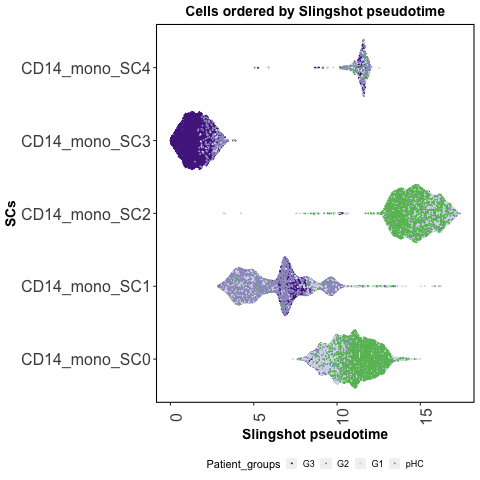

In [44]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_3, y = SCs, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")

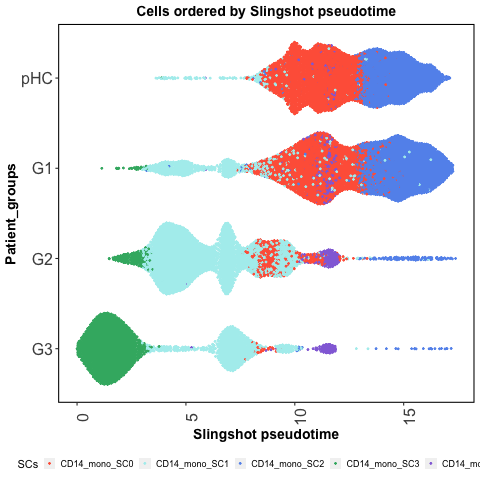

In [45]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_3, y = Patient_groups, colour = SCs)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.5) + scale_color_manual(values = colour_map) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")

### 4.5 Plotting Start Clus: CD14_mono_SC4

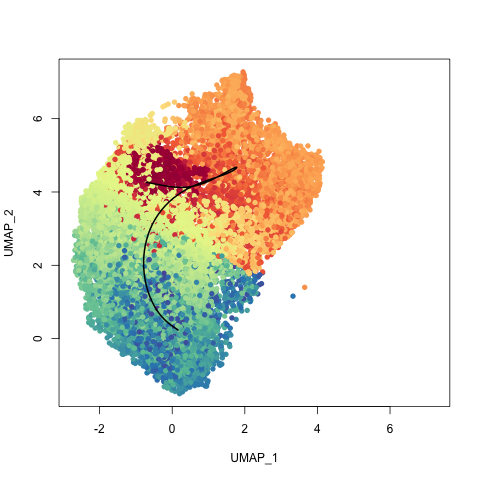

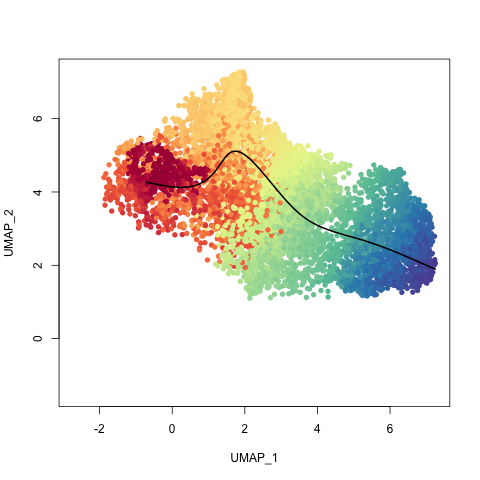

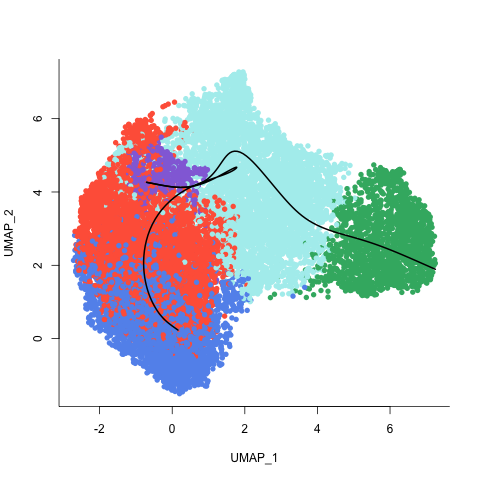

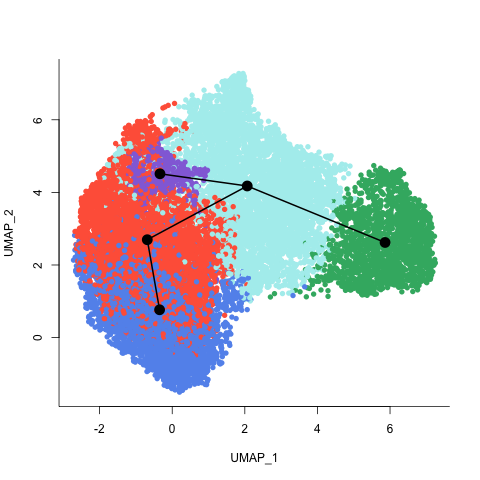

In [46]:
%%R 
#Plotting Slingshot lineages and curves
colour_map = c('tomato', 'paleturquoise', 'cornflowerblue', 'mediumseagreen',
       'mediumpurple', 'goldenrod', 'lightgreen', 'palevioletred',
       'lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue',
       'yellowgreen', 'mediumorchid', 'mediumturquoise', 'peru',
       '#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue',
       '#4daf4a', '#377eb8')

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_1,breaks=100)], pch=16, xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_4)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colors[cut(adata_sling_4$slingPseudotime_2,breaks=100)], pch=16,xlab='UMAP_1', ylab='UMAP_2')
lines(slingCurves(adata_sling_4)$curve2, lwd=2)

#Plot of All Curves
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_sling_4)$UMAP, col = colour_map[CD14$SCs], pch=16, bty = 'L', xlab='UMAP_1', ylab='UMAP_2') + lines(slingCurves(adata_sling_4)$curve1,lwd=2) + lines(slingCurves(adata_sling_4)$curve2,lwd=2) + lines(slingCurves(adata_sling_4)$curve3,lwd=2)+ lines(slingCurves(adata_sling_4)$curve4,lwd=2) + lines(slingCurves(adata_sling_4)$curve5,lwd=2)+lines(slingCurves(adata_sling_4)$curve6,lwd=2)
#legend(x=4.1, y=1.7, legend=unique(colData(adata)$Res0_8), fill=colour_map[as.integer(unique(colData(CD14)$CD14cells_Res0_4))])

par(xpd=TRUE)
plot(reducedDims(adata_sling_4)$UMAP[,c(1,2)], col = colour_map[CD14$SCs], pch=16, asp = 1, bty='L', xlab='UMAP_1', ylab='UMAP_2')
lines(SlingshotDataSet(adata_sling_4), lwd=2, type='lineages')

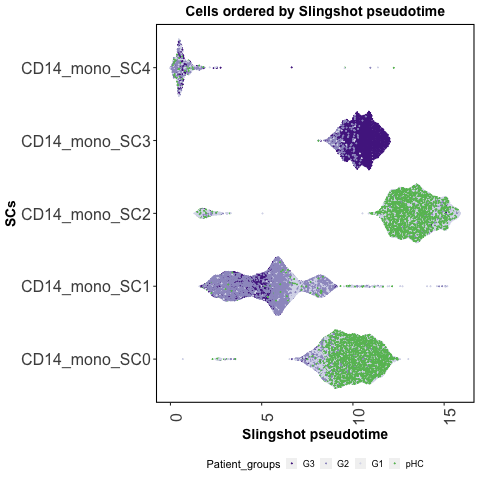

In [47]:
%%R 
#Violin Plots of Clusters across Groups
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_4, y = SCs, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


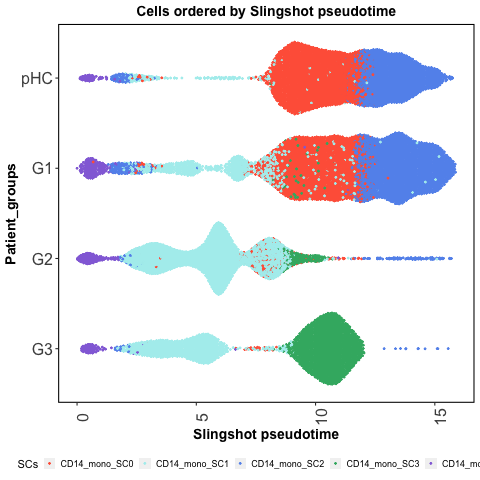

In [48]:
%%R 
#Violin Plots of Groups across Clusters
ggplot(as.data.frame(colData(CD14)), aes(x = sling_avg_4, y = Patient_groups, colour = SCs)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.5) + scale_color_manual(values = colour_map) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime")


# 5. Plotting Gene Expression Heatmap

Here, we begin to plot a heatmap to show the top 100 genes that change across the pseudotime. In doing so, we can find genes that differentiate the cells as described by the trajectory inference. 

At this point we select the slingshot trajectory that makes the most sense biological sense in the context of our project; in this case, it was with start cluster "CD14_mono_SC0," or "sling_avg_0." Using the generalized additive model (gam), the gene expression and pseudotime are smoothed. We then use these results to plot the heatmap.

Note: This portion of the pipeline is the most computationally intensive and time-consuming part of the pipeline. Depending on the number of cells and computer specs, this process can take at least a few hours.

### 5.1 Running GAM

In [49]:
%%R -i CD14

#Set the pseudotime variable
sling_values = data.frame(slingPseudotime_0 = CD14$sling_avg_0)
t <- sling_values[ , c("slingPseudotime_0")]

#Extracting the gene expression matrix
Y <- assay(CD14)

# Using GAM with a loess term for pseudotime
gam.pval <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

### 5.2 Extracting Top 100 Genes

In [50]:
%%R
#Select the top 100 most significant genes that change over pseudotime
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]
heatdata <- assay(CD14)[rownames(assay(CD14)) %in% topgenes, order(t, na.last = NA)]
write.csv(heatdata,'./Files/heatdata.csv')



In [51]:
heatdata = pd.read_csv('./Files/heatdata.csv')
heatdata = heatdata.set_index('Unnamed: 0')
heatdata = heatdata.rename_axis(None)
heatdata

CAACAGTGTCTGTCCT-12  TTCTAGTCAGCACAGA-9  TGATGGTAGCGAATGC-12  \
ISG15                1.636113            1.389180             1.304558   
RBP7                -0.209696           -0.209696            -0.209696   
PADI4               -0.180585           -0.180585            -0.180585   
IFI6                 1.208378           -0.640703             1.316100   
IFI44L              -0.693029            1.332679            -0.693029   
...                       ...                 ...                  ...   
LGALS2               5.025827            4.226640             3.496708   
H1F0                -0.168937           -0.168937            -0.168937   
APOBEC3A             4.686058            4.598620             2.845743   
MX2                  1.711216           -0.574752             1.391241   
MX1                  1.736495           -0.694645             0.315676   

          TGTACAGCATGAGATA-12  AAGCGAGCAATGGGTG-12  GATGACTAGACATATG-12  \
ISG15                1.795035             0.927951             0.586798   
RBP7                 1.885978             2.981983             3.462677   
PADI4               -0.180585            -0.180585            -0.180585   
IFI6                 1.200468             1.520814             0.743614   
IFI44L               1.083071             1.427216             1.035254   
...                       ...                  ...                  ...   
LGALS2               2.155623             5.951181             4.893218   
H1F0                 4.716937             2.759024            -0.168937   
APOBEC3A             5.198100             3.991015             3.538896   
MX2                  0.976130             0.912629            -0.574752   
MX1                  1.449632             0.028812             0.637529   

          AGTGACTCACCCTAAA-12  CCTCATGGTACCATAC-12  CCTGCATGTGGGTATG-12  \
ISG15                0.749006            -0.209411             0.305888   
RBP7                 3.954106            -0.209696             3.208437   
PADI4               -0.180585             1.847856            -0.180585   
IFI6                 1.979853             1.162222             1.452603   
IFI44L               1.068446             1.373926             0.422837   
...                       ...                  ...                  ...   
LGALS2               2.757272             4.485940             5.289171   
H1F0                -0.168937             2.022809             6.152060   
APOBEC3A             4.974680             2.828092             3.808476   
MX2                  0.959500             0.936926            -0.574752   
MX1                  1.061587            -0.153096             0.867182   

          TTACCGCGTGGTTTAC-12  ...  AGACACTGTCCGCAGT-33  TCAATCTAGTCATACC-33  \
ISG15                0.508551  ...            -0.073942             0.950376   
RBP7                 3.230385  ...             5.977791             6.363981   
PADI4                4.493617  ...             2.307318             4.606781   
IFI6                 1.462888  ...            -0.640703             1.974359   
IFI44L               0.430002  ...            -0.095281             0.457192   
...                       ...  ...                  ...                  ...   
LGALS2               4.414138  ...            -0.239815            -0.239815   
H1F0                -0.168937  ...             7.816664             3.124089   
APOBEC3A             1.797099  ...             2.994378             1.846978   
MX2                  2.025860  ...             0.808704             0.470526   
MX1                  0.876115  ...             1.422466             0.583476   

          GAATCGTGTCGAATGG-33  TAGCACATCGCGCTGA-33  AGTCACACACACCTGG-33  \
ISG15                1.304002             1.011990             0.828299   
RBP7                 5.245424            -0.209696            -0.209696   
PADI4                2.678716             2.752631             4.588720   
IFI6                 1.882654             1.628219        

In [52]:
heatdata_val = pd.read_csv('./Files/heatdata.csv')
heatdata_val = heatdata_val.T
heatdata_val = heatdata_val.rename(columns=heatdata_val.iloc[0])
heatdata_val = heatdata_val.drop(heatdata_val.index[0])
heatdata_val.head()

pseudo_adata = CD14
index = heatdata_val.index
pseudo_adata.obs = pseudo_adata.obs.reindex(index) 
pseudo_adata.obs.head()

heatdata_val['sling_avg_0'] = pseudo_adata.obs['sling_avg_0']
heatdata_val['SCs'] = pseudo_adata.obs['SCs']
heatdata_val['Patient_groups'] = pseudo_adata.obs['Patient_groups']
heatdata_val.head(100)

ISG15      RBP7     PADI4       IFI6    IFI44L  \
CAACAGTGTCTGTCCT-12   1.63611 -0.209696 -0.180585    1.20838 -0.693029   
TTCTAGTCAGCACAGA-9    1.38918 -0.209696 -0.180585  -0.640703   1.33268   
TGATGGTAGCGAATGC-12   1.30456 -0.209696 -0.180585     1.3161 -0.693029   
TGTACAGCATGAGATA-12   1.79503   1.88598 -0.180585    1.20047   1.08307   
AAGCGAGCAATGGGTG-12  0.927951   2.98198 -0.180585    1.52081   1.42722   
...                       ...       ...       ...        ...       ...   
AAGACAACAGGTATGG-12   1.11322 -0.209696 -0.180585   0.180054   1.12736   
CTCCGATTCGTTGTTT-12  0.583487   2.13956 -0.180585    1.35054   1.37543   
TGACAGTCATTCTCTA-15  0.303028 -0.209696 -0.180585    0.73741  0.881809   
GCAGCCAGTGATGGCA-12  0.671973   4.82187 -0.180585    1.64692   1.13311   
TCCGAAATCGTCAGAT-12 -0.408324   1.58215   2.25408  0.0347397   1.05891   

                        IFI44      RHOC  S100A10   S100A9   S100A12  ...  \
CAACAGTGTCTGTCCT-12 -0.441873   4.41055  1.97571  2.53982   1.52306  ...   
TTCTAGTCAGCACAGA-9    3.16898 -0.282339  1.69643  2.49314 -0.267883  ...   
TGATGGTAGCGAATGC-12   1.17882 -0.282339  2.40616  2.17219   1.99059  ...   
TGTACAGCATGAGATA-12    2.0045    3.5807  2.53962  2.50752   1.51372  ...   
AAGCGAGCAATGGGTG-12 -0.441873   2.92089  2.72784  2.24797   2.55274  ...   
...                       ...       ...      ...      ...       ...  ...   
AAGACAACAGGTATGG-12  0.825144   1.43973  2.49939   2.8971   1.57192  ...   
CTCCGATTCGTTGTTT-12 -0.441873 -0.282339   1.8835  3.18604   1.69281  ...   
TGACAGTCATTCTCTA-15  0.572368   3.53303  1.78826  1.27769  0.665199  ...   
GCAGCCAGTGATGGCA-12   0.83138 -0.282339  1.79057  2.14739   1.57952  ...   
TCCGAAATCGTCAGAT-12  0.600819 -0.282339  2.11372  2.70747   3.17197  ...   

                       MCEMP1    ZFP36    LGALS2      H1F0  APOBEC3A  \
CAACAGTGTCTGTCCT-12 -0.146321  2.84489   5.02583 -0.168937   4.68606   
TTCTAGTCAGCACAGA-9  -0.146321   2.5435   4.22664 -0.168937   4.59862   
TGATGGTAGCGAATGC-12 -0.146321  2.70934   3.49671 -0.168937   2.84574   
TGTACAGCATGAGATA-12   3.20485  2.77915   2.15562   4.71694    5.1981   
AAGCGAGCAATGGGTG-12 -0.146321  2.58684   5.95118   2.75902   3.99101   
...                       ...      ...       ...       ...       ...   
AAGACAACAGGTATGG-12   3.33544  2.25577   4.11537 -0.168937 -0.263097   
CTCCGATTCGTTGTTT-12 -0.146321  2.50597    4.6204   5.20808   1.93029   
TGACAGTCATTCTCTA-15 -0.146321  2.64291 -0.239815   5.19845    3.8517   
GCAGCCAGTGATGGCA-12   3.35258  1.01884   4.12841   6.20593   3.37133   
TCCGAAATCGTCAGAT-12 -0.146321  2.47711    4.9504 -0.168937   3.39698   

                          MX2        MX1 sling_avg_0            SCs  \
CAACAGTGTCTGTCCT-12   1.71122    1.73649    0.000000  CD14_mono_SC0   
TTCTAGTCAGCACAGA-9  -0.574752  -0.694645    0.036303  CD14_mono_SC0   
TGATGGTAGCGAATGC-12   1.39124   0.315676    0.064180  CD14_mono_SC0   
TGTACAGCATGAGATA-12   0.97613    1.44963    0.222081  CD14_mono_SC0   
AAGCGAGCAATGGGTG-12  0.912629  0.0288121    0.270144  CD14_mono_SC0   
...                       ...        ...         ...            ...   
AAGACAACAGGTATGG-12 -0.574752   0.552019    0.832549  CD14_mono_SC0   
CTCCGATTCGTTGTTT-12  0.520047    0.63394    0.834443  CD14_mono_SC0   
TGACAGTCATTCTCTA-15  0.751786   0.631559    0.835324  CD14_mono_SC0   
GCAGCCAGTGATGGCA-12   1.03341  0.0990848    0.836239  CD14_mono_SC0   
TCCGAAATCGTCAGAT-12 -0.574752 -0.0446441    0.838984  CD14_mono_SC0   

                    Patient_groups  
CAACAGTGTCTGTCCT-12             G2  
TTCTAGTCAGCACAGA-9              G3  
TGATGGTAGCGAATGC-12             G2  
TGTACAGCATGAGATA-12             G2  
AAGCGAGCAATGGGTG-12             G2  
...                            ...  
AAGACAACAGGTATGG-12             G2  
CTCCGATTCGTTGTTT-12             G2  
TGACAGTCATTCTCTA-15             G2  
GCAGCCAGTGATGGCA-12             G2  
TCCGAAATCGTCAGAT-12             G2  

[100 rows x 103 columns]

### 5.3 Plotting Heatmap

In [53]:
#col_pGroups = ["#D8DAEB", "#9E9AC8", "#54278F","#66BD63"]
col_pGroups = ["#9E9AC8", "#54278F", "#66BD63","#D8DAEB",]

pGroups_dict = dict(zip( pseudo_adata.obs['Patient_groups'].unique(), col_pGroups))
pGroups = pseudo_adata.obs['Patient_groups']
pGroups_colors = pd.Series(pGroups).map(pGroups_dict)

colour_map = ['tomato', 'paleturquoise','cornflowerblue', 'mediumseagreen','mediumpurple', 'goldenrod', 'lightgreen', 
              'palevioletred','lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue','yellowgreen', 'mediumorchid',
              'mediumturquoise', 'peru','#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue','#4daf4a', 
              '#377eb8']

colour_map = ['tomato', 'paleturquoise','mediumpurple','cornflowerblue', 'mediumseagreen', 'goldenrod', 'lightgreen', 
              'palevioletred','lightsalmon', 'thistle', 'brown', 'plum', 'lightskyblue','yellowgreen', 'mediumorchid',
              'mediumturquoise', 'peru','#bf812d', 'mediumaquamarine', 'lightslategrey', 'dodgerblue','#4daf4a', 
              '#377eb8']

SCs_dict = dict(zip( pseudo_adata.obs['SCs'].unique(), colour_map))
SCs = pseudo_adata.obs['SCs']
SCs_colors = pd.Series(SCs).map(SCs_dict)



/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


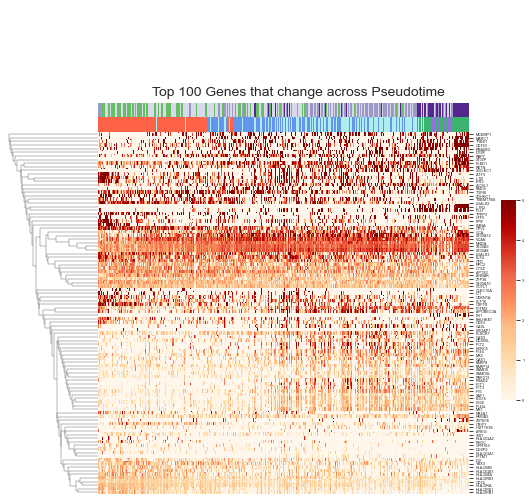

In [54]:
sb.set(font_scale=.5)
g = sb.clustermap(heatdata, cmap = 'OrRd', 
             col_colors = [pGroups_colors,SCs_colors],
             vmin=0, vmax=5,
             row_cluster=True, col_cluster=False,
             linewidths=0, xticklabels=False, yticklabels=True, cbar_pos=(1, .2, .03, .4),
             annot_kws={"fontsize":8}
)

for label in pGroups.unique():
    g.ax_col_dendrogram.bar(0, 0, color=pGroups_dict[label],
                            label=label, linewidth=0)
for label in SCs.unique():
    g.ax_row_dendrogram.bar(0, 0, color=SCs_dict[label],
                            label=label, linewidth=0)

plt.title('Top 100 Genes that change across Pseudotime',x=-13.5, y=1.5, fontsize=20)
plt.show()

# 6. Plotting Gene Expression Scatterplots

Here, we plot individual gene expressions, where we select specific genes we would like to plot. In each of the plots, the pseudotime falls on the x-axis and the gene expression score or label lies on the y-axis. All of the gene expression calculations (ISG scores, Inflammation Score, etc.) were done outside this pipeline, but individual gene expressions should not need supplemental calculations.   

In [55]:
#--- Reordering Labels for Plotting
CD14.obs['IL1B_IFI27'] = CD14.obs['IL1B_IFI27'].cat.reorder_categories(['Neither','IL1B','IFI27','IL1B_IFI27'])
CD14.obs['IL1B_ISG15'] = CD14.obs['IL1B_ISG15'].cat.reorder_categories(['Neither','IL1B','ISG15','IL1B_ISG15'])
CD14.obs['IL1B_XAF1'] = CD14.obs['IL1B_XAF1'].cat.reorder_categories(['Neither','IL1B','XAF1','IL1B_XAF1'])
CD14.obs['CXCL8_IFI27'] = CD14.obs['CXCL8_IFI27'].cat.reorder_categories(['Neither','CXCL8','IFI27','CXCL8_IFI27'])
CD14.obs['CXCL8_ISG15'] = CD14.obs['CXCL8_ISG15'].cat.reorder_categories(['Neither','CXCL8','ISG15','CXCL8_ISG15'])
CD14.obs['CXCL8_XAF1'] = CD14.obs['CXCL8_XAF1'].cat.reorder_categories(['Neither','CXCL8','XAF1','CXCL8_XAF1'])


/opt/anaconda3/envs/scanpy_R/lib/python3.6/site-packages/anndata2ri/py2r.py:38: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


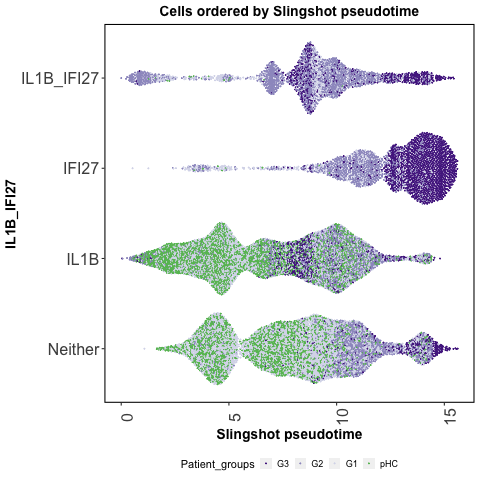

In [56]:
%%R -i CD14
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$IL1B_IFI27, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_IFI27")

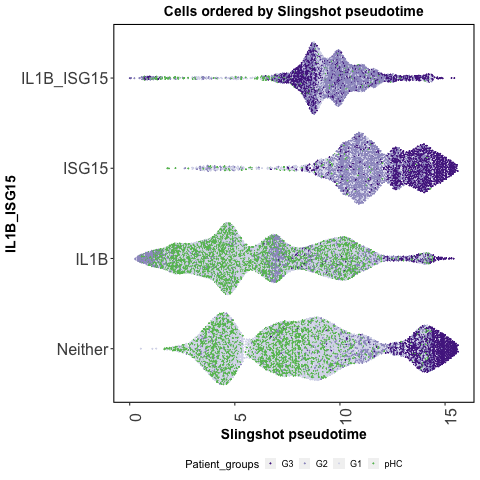

In [57]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$IL1B_ISG15, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_ISG15")

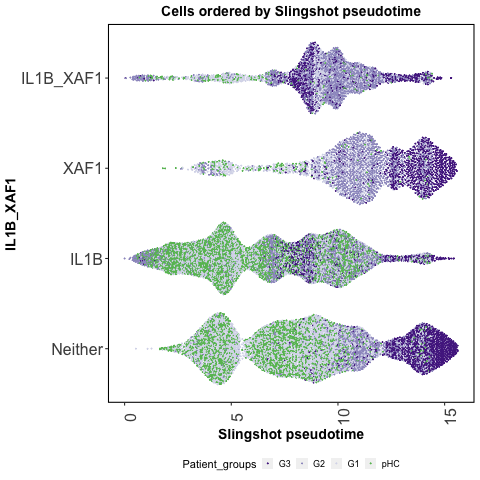

In [58]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$IL1B_XAF1, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("IL1B_XAF1")


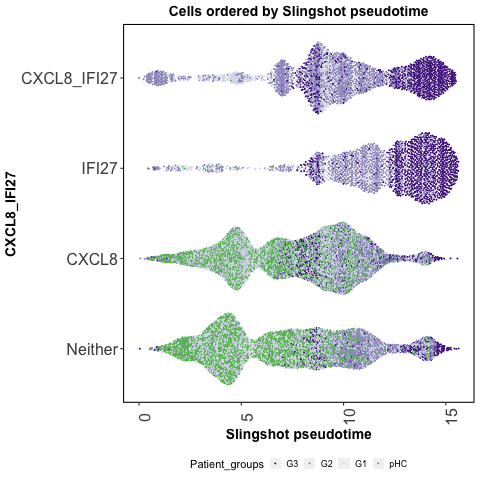

In [59]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$CXCL8_IFI27, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_IFI27")

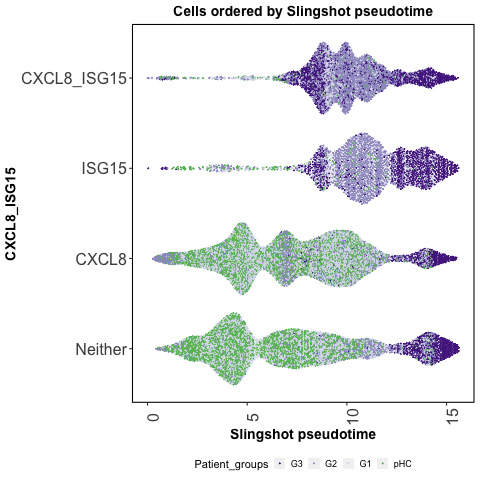

In [60]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$CXCL8_ISG15, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_ISG15")

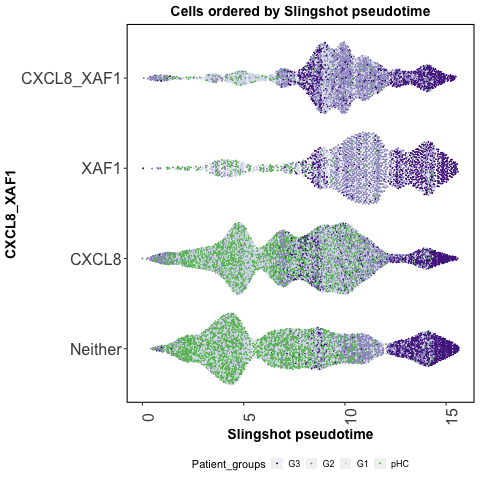

In [61]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$CXCL8_XAF1, colour = Patient_groups)) + 
geom_quasirandom(groupOnX = FALSE,size = 0.1) + scale_color_manual(values = col_pGroups) + THEME + 
xlab("Slingshot pseudotime") + ggtitle("Cells ordered by Slingshot pseudotime") + ylab("CXCL8_XAF1")

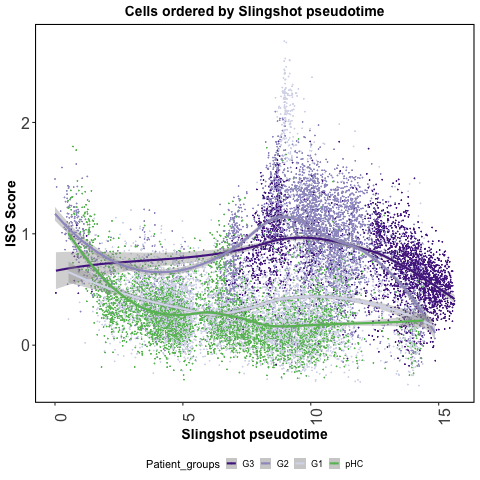

In [62]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$ISG_score, colour = Patient_groups)) + 
geom_point(size = 0.01) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + 
ylab("ISG Score") + ggtitle("Cells ordered by Slingshot pseudotime") + geom_smooth(aes(shape = NULL), method = "loess",se=TRUE) + ylab("ISG Score")


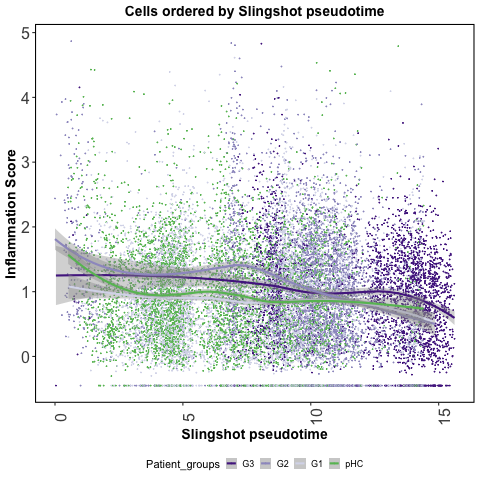

In [63]:
%%R
ggplot(as.data.frame(colData(CD14)), aes(x=CD14$sling_avg_0, y=CD14$INFLAM_score, colour = Patient_groups)) + 
geom_point(size = 0.01) + scale_color_manual(values = col_pGroups) + THEME + xlab("Slingshot pseudotime") + 
ylab("Inflammation Score") + ggtitle("Cells ordered by Slingshot pseudotime") + geom_smooth(aes(shape = NULL), method = "loess",se=TRUE)


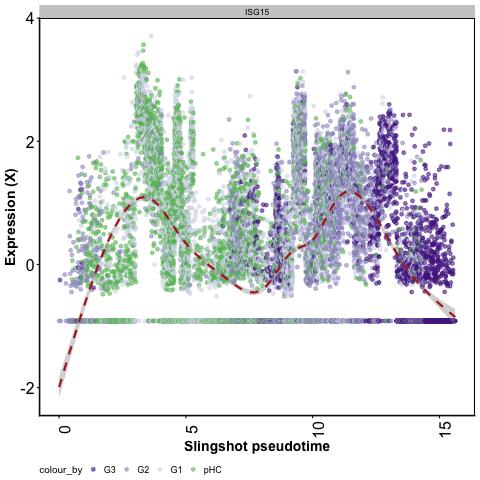

In [64]:
%%R
plotExpression(CD14, "ISG15",exprs_values= 'X', x = "sling_avg_0",colour_by = "Patient_groups",show_violin = TRUE,show_smooth = TRUE) + 
scale_color_manual(values = col_pGroups) + THEME  + xlab("Slingshot pseudotime") 
